In [1]:
## Import all the necessary libraries 

import warnings
warnings.filterwarnings('ignore') # ignore any warnings 

# import all data utilities 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import zipfile

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay
from scipy.stats import ks_2samp
from scipy.stats import entropy
from sklearn.preprocessing import StandardScaler, MinMaxScaler

# import all the various classifier models 
#import xgboost
import xgboost as xgb
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


In [2]:
def get_transformed_data(sub_df):
    
    #for col in sub_df:
    #    if sub_df[col].sum()==0:
    #        sub_df.drop(col, inplace=True, axis=1)  
    sub_df.drop_duplicates(keep=False)
    sub_df['Label'] = sub_df['Label'].map({'non-malicious': 1, 'malicious': 0})
    
    return sub_df

In [3]:
def setplotParams():
    # Set the plot params

    plt.rcParams["figure.figsize"] = [9, 5]
    plt.rcParams["figure.autolayout"] = True
    plt.rcParams["axes.edgecolor"] = "black"
    plt.rcParams["axes.labelsize"] = 7
    plt.rcParams["axes.titlepad"] = 8
    plt.rcParams["axes.facecolor"] = "white"
    plt.rcParams["axes.linewidth"] = 0.3
    plt.rcParams["axes.grid"] = True
    plt.rcParams["grid.color"] = "green"
    plt.rcParams["grid.linestyle"] = "--"
    plt.rcParams["grid.linewidth"] = 0.2
    plt.rcParams["xtick.labelsize"] = 6
    plt.rcParams["ytick.labelsize"] = 6
    plt.rcParams["legend.fontsize"] = 7
    plt.rcParams["legend.labelspacing"] = 0.6
    plt.rcParams["lines.linewidth"] = 0.5
    

In [4]:
real_filepath = '../Real Datasets/Malware Detection/malware_detection.csv'
#synthetic_filepath = '../Synthetic Datasets/sdv_gauss/sdv_gauss_malware_detection.csv'
#synthetic_filepath = '../Synthetic Datasets/sdv_ctgan/sdv_ctgan_malware_detection_10000.csv'
#synthetic_filepath = '../Synthetic Datasets/sdv_copula/sdv_copula_malware_detection.csv'
synthetic_filepath = '../Synthetic Datasets/sdv_tvae/sdv_tvae_malware_detection_10000.csv'


real_df = pd.read_csv(real_filepath)
synthetic_df = pd.read_csv(synthetic_filepath)
synthetic_df.drop('Unnamed: 0', inplace=True, axis = 1)

rtrf_df = get_transformed_data(real_df)
strf_df = get_transformed_data(synthetic_df)
strf_df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Columns: 532 entries, Label to F_531
dtypes: int64(532)
memory usage: 40.6 MB


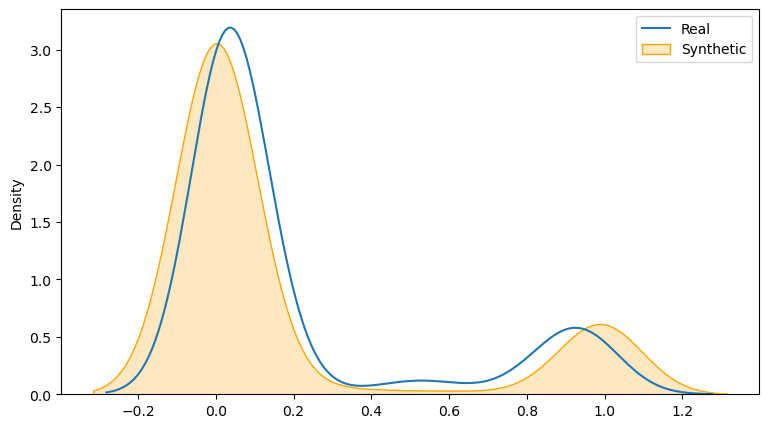

In [5]:
fig = plt.figure(figsize=(9,5))
sns.kdeplot(rtrf_df.mean(), legend=True, label='Real')
sns.kdeplot(strf_df.mean(), color='orange', fill=True, legend=True, label='Synthetic')
plt.legend()
plt.show()


In [6]:
rtrf_df['Label'].value_counts()

0    301
1     72
Name: Label, dtype: int64

In [7]:
strf_df['Label'].value_counts()

0    7855
1    2145
Name: Label, dtype: int64

Text(0, 0.5, 'Count')

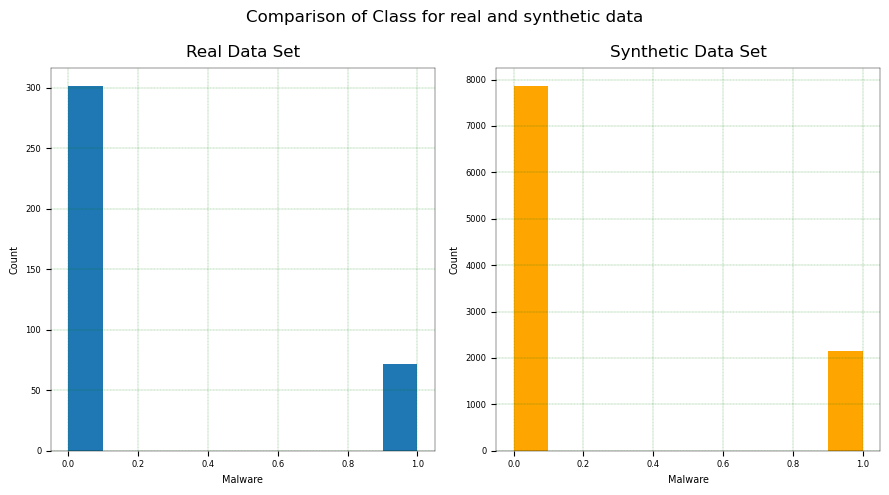

In [8]:
setplotParams()

fig, (axes0, axes1) = plt.subplots(1,2)
fig.suptitle('Comparison of Class for real and synthetic data')

axes0.hist(real_df['Label'], rwidth=1)
axes0.set_title('Real Data Set')
axes0.set_xlabel('Malware')
axes0.set_ylabel('Count')

axes1.hist(synthetic_df['Label'], color='orange')
axes1.set_title('Synthetic Data Set')
axes1.set_xlabel('Malware')
axes1.set_ylabel('Count')


In [9]:
z_col = 0
for col in real_df:
    if real_df[col].sum()==0:
        z_col += 1
print('Number of columns in real dataset with only one categorical (constant) values are '+str(z_col))
z_col = 0
for col in synthetic_df:
    if synthetic_df[col].sum()==0:
        z_col += 1
print('Number of columns in synthetic dataset with only one categorical (constant) values are '+str(z_col))

Number of columns in real dataset with only one categorical (constant) values are 28
Number of columns in synthetic dataset with only one categorical (constant) values are 343


In [10]:
# Percentage of class variables 
real_len = len(real_df)
survival_per = (real_len - (real_df['Label'].value_counts()[0]))/real_len
print('Malware detected percentage in real dataset '+str(survival_per*100)+' %')

Malware detected percentage in real dataset 19.302949061662197 %


In [11]:
synth_len = len(synthetic_df)
survival_per = (synth_len - (synthetic_df['Label'].value_counts()[0]))/synth_len
print('Malware detected percentage in synthetic dataset '+str(survival_per*100)+' %')

Malware detected percentage in synthetic dataset 21.45 %


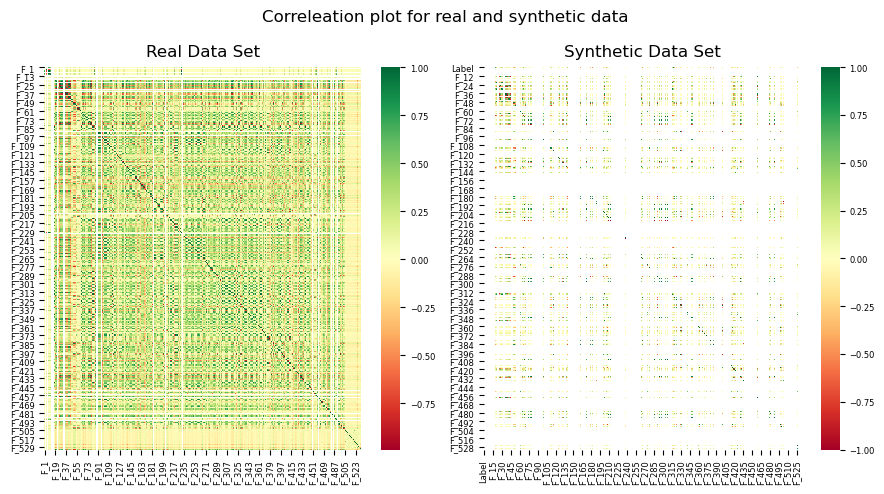

In [12]:
corrmat=rtrf_df.corr()
top_corr_features=corrmat.index

syn_corr = strf_df.corr()
top_corr_features_syn =syn_corr.index

fig, axes = plt.subplots(1,2) # 1 row and 2 column
fig.suptitle('Correleation plot for real and synthetic data')

axes[0].set_title('Real Data Set')
g1=sns.heatmap(real_df[top_corr_features].corr(),annot=False, cmap='RdYlGn', ax= axes[0])
axes[1].set_title('Synthetic Data Set')
g2=sns.heatmap(synthetic_df[top_corr_features_syn].corr(),annot=False, cmap='RdYlGn', ax= axes[1])


As all the Attributes are categorical, Two-sample Kolmogorov–Smirnov test and KL-Divergence are no applied,

In [13]:
def consolidate_report(rep, tag):
    rep['Type'] = 0
    rep = rep[list(('Type','age', 'avg_glucose_level', 'bmi'))]
    rep['Type'] = tag
    return rep

# Calculating Euclidean Distance

In [14]:
# finding sum of squares
def euclidean(rtrf_df, strf_df):
    sum_sq = np.sum(np.square(rtrf_df - strf_df))
    dist = np.sqrt(sum_sq)
    #print('the Euclidean distance between 2 dataframe is : ' +str(dist) )
    return dist

dist = euclidean(rtrf_df, strf_df[0:len(rtrf_df)])
result = pd.DataFrame(dist).T
result.describe()

#result.columns= ['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked']
#final_report = final_report.append(consolidate_report(result, 'Eucledian Distance'))
#final_report

,F_1,F_10,F_100,F_101,F_102,F_103,F_104,F_105,F_106,F_107,...,F_91,F_92,F_93,F_94,F_95,F_96,F_97,F_98,F_99,Label
count,1.0,1.0,1.000000,1.00000,1.000000,1.00000,1.000000,1.00000,1.000000,1.000000,...,1.000000,1.0,1.000000,1.000000,1.000000,1.0,1.000000,1.000000,1.000000,1.000000
mean,1.0,0.0,4.690416,2.44949,2.645751,2.44949,2.645751,2.44949,2.645751,3.162278,...,2.828427,3.0,2.828427,4.690416,3.162278,0.0,3.605551,4.242641,2.828427,11.575837
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,1.0,0.0,4.690416,2.44949,2.645751,2.44949,2.645751,2.44949,2.645751,3.162278,...,2.828427,3.0,2.828427,4.690416,3.162278,0.0,3.605551,4.242641,2.828427,11.575837
25%,1.0,0.0,4.690416,2.44949,2.645751,2.44949,2.645751,2.44949,2.645751,3.162278,...,2.828427,3.0,2.828427,4.690416,3.162278,0.0,3.605551,4.242641,2.828427,11.575837
50%,1.0,0.0,4.690416,2.44949,2.645751,2.44949,2.645751,2.44949,2.645751,3.162278,...,2.828427,3.0,2.828427,4.690416,3.162278,0.0,3.605551,4.242641,2.828427,11.575837
75%,1.0,0.0,4.690416,2.44949,2.645751,2.44949,2.645751,2.44949,2.645751,3.162278,...,2.828427,3.0,2.828427,4.690416,3.162278,0.0,3.605551,4.242641,2.828427,11.575837
max,1.0,0.0,4.690416,2.44949,2.645751,2.44949,2.645751,2.44949,2.645751,3.162278,...,2.828427,3.0,2.828427,4.690416,3.162278,0.0,3.605551,4.242641,2.828427,11.575837


# Calculating Hellinger Distance

This is another meas to measure the probability difference between 2 distributions or 2 variables. The larger the difference separate they are

In [15]:
def hellinger(p, q):
    result = 0 
  # distance between p an d
  # p and q are np array probability distributions
    n = len(p)
    sum = 0.0
    for i in range(n):
        sum += (np.sqrt(p[i]) - np.sqrt(q[i]))**2
        result = (1.0 / np.sqrt(2.0)) * np.sqrt(sum)
    return result

In [16]:
h_dist = hellinger(rtrf_df.to_numpy(), strf_df[0:len(rtrf_df)].to_numpy())

h_result = pd.DataFrame(h_dist).T
h_result.describe()
#h_result.columns = ['Survived', 'Pclass', 'Sex', 'Age', 'Fare', 'Embarked']
#final_report = final_report.append(consolidate_report(h_result, 'Hellinger Distance'))
#final_report

,0,1,2,3,4,5,6,7,8,9,...,522,523,524,525,526,527,528,529,530,531
count,1.000000,1.0000,1.000000,1.000000,1.000000,1.0000,1.000000,1.0000,1.000000,1.0000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0
mean,11.874342,13.6565,13.619838,13.638182,13.619838,13.6565,13.619838,13.6565,13.619838,13.6565,...,4.472136,4.062019,4.301163,9.874209,7.071068,4.123106,3.872983,9.949874,8.306624,6.0
std,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
min,11.874342,13.6565,13.619838,13.638182,13.619838,13.6565,13.619838,13.6565,13.619838,13.6565,...,4.472136,4.062019,4.301163,9.874209,7.071068,4.123106,3.872983,9.949874,8.306624,6.0
25%,11.874342,13.6565,13.619838,13.638182,13.619838,13.6565,13.619838,13.6565,13.619838,13.6565,...,4.472136,4.062019,4.301163,9.874209,7.071068,4.123106,3.872983,9.949874,8.306624,6.0
50%,11.874342,13.6565,13.619838,13.638182,13.619838,13.6565,13.619838,13.6565,13.619838,13.6565,...,4.472136,4.062019,4.301163,9.874209,7.071068,4.123106,3.872983,9.949874,8.306624,6.0
75%,11.874342,13.6565,13.619838,13.638182,13.619838,13.6565,13.619838,13.6565,13.619838,13.6565,...,4.472136,4.062019,4.301163,9.874209,7.071068,4.123106,3.872983,9.949874,8.306624,6.0
max,11.874342,13.6565,13.619838,13.638182,13.619838,13.6565,13.619838,13.6565,13.619838,13.6565,...,4.472136,4.062019,4.301163,9.874209,7.071068,4.123106,3.872983,9.949874,8.306624,6.0


#### Testing Privacy is not applicable for this dataset as all variables are categorical and there is no privacy identifier

# Testing with model

In [17]:
rtrf_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Columns: 532 entries, F_1 to Label
dtypes: int64(532)
memory usage: 1.5 MB


In [18]:
y = rtrf_df['Label']
y_synthetic = strf_df['Label']
x = rtrf_df.drop('Label', axis=1)
x_synthetic = strf_df.drop('Label', axis=1)

#modelevaluation.validate_data(x,y,x_synthetic, y_synthetic)

In [19]:
scaler_x = StandardScaler()
X = scaler_x.fit_transform(x)
scaler_xs = StandardScaler()
X_synthetic = scaler_xs.fit_transform(x_synthetic)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3)
X_synth_train, X_synth_test, y_synth_train, y_synth_test = train_test_split(X_synthetic, y_synthetic, test_size = 0.3)

In [20]:
xg_class = xgb.XGBClassifier(learning_rate = 0.3, max_depth = 5, n_estimators = 10)
svm_class = svm.SVC(kernel='linear', gamma='auto', C=2)
log_class = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, solver = 'saga')
knn_class = KNeighborsClassifier(n_neighbors= 10, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                 metric='minkowski', metric_params=None, n_jobs=None)
dt_class = DecisionTreeClassifier(max_depth = 30, 
                                  random_state=42, 
                                  max_leaf_nodes=15, 
                                  class_weight='balanced')
rf_class = RandomForestClassifier(n_estimators=10,
                                  min_samples_split=2,
                                  min_samples_leaf=1)

classifier_list = [[xg_class, 'XGBoost'], [svm_class, 'SVM'], [log_class,'Logistic'], [knn_class,'KNN'], 
                   [dt_class,'Decission Tree'], [rf_class,'Random Forest']] 

--------------------------------------------------
 Generating report for : XGBoost model
[10:50:41] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 The Score of the trained model is -- : 0.9961685823754789


 The Prediction Score  is -- : 0.9821428571428571


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        91
           1       1.00      0.90      0.95        21

    accuracy                           0.98       112
   macro avg       0.99      0.95      0.97       112
weighted avg       0.98      0.98      0.98       112

The Confusion matrix is 


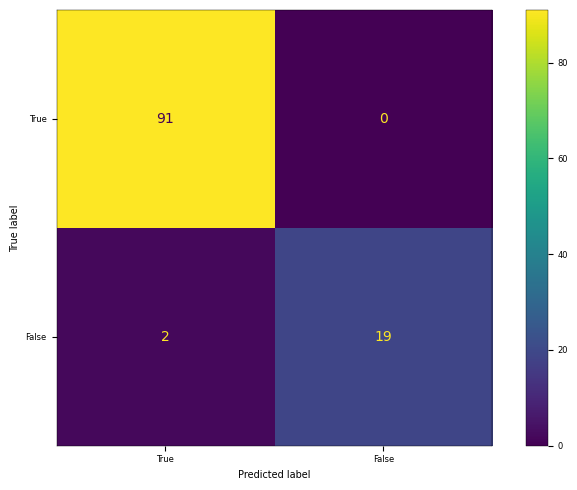

--------------------------------------------------
 Generating report for : SVM model
 The Score of the trained model is -- : 1.0


 The Prediction Score  is -- : 0.9910714285714286


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        91
           1       1.00      0.95      0.98        21

    accuracy                           0.99       112
   macro avg       0.99      0.98      0.99       112
weighted avg       0.99      0.99      0.99       112

The Confusion matrix is 


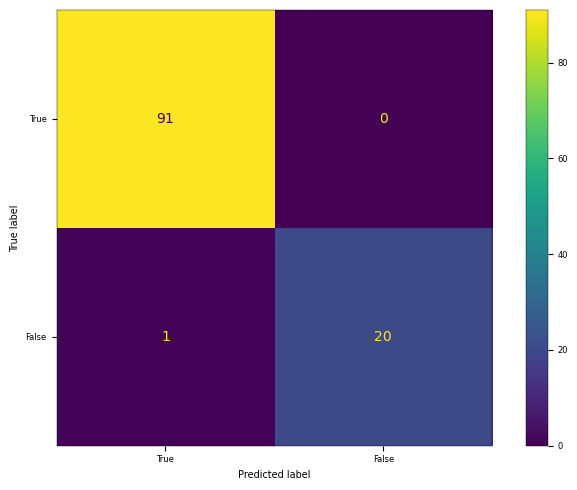

--------------------------------------------------
 Generating report for : Logistic model
 The Score of the trained model is -- : 1.0


 The Prediction Score  is -- : 0.9910714285714286


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        91
           1       1.00      0.95      0.98        21

    accuracy                           0.99       112
   macro avg       0.99      0.98      0.99       112
weighted avg       0.99      0.99      0.99       112

The Confusion matrix is 


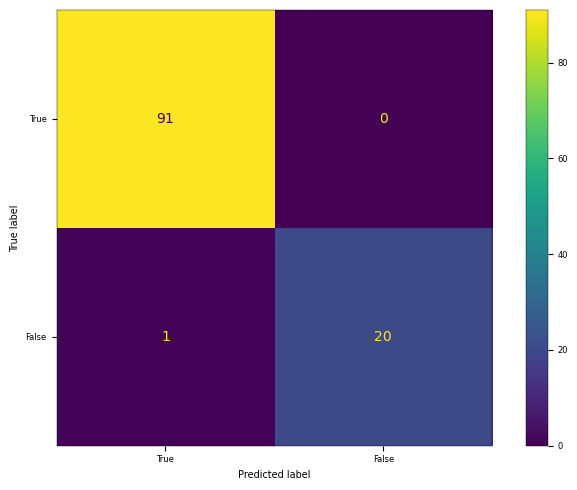

--------------------------------------------------
 Generating report for : KNN model
 The Score of the trained model is -- : 0.9540229885057471


 The Prediction Score  is -- : 0.9285714285714286


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.92      1.00      0.96        91
           1       1.00      0.62      0.76        21

    accuracy                           0.93       112
   macro avg       0.96      0.81      0.86       112
weighted avg       0.93      0.93      0.92       112

The Confusion matrix is 


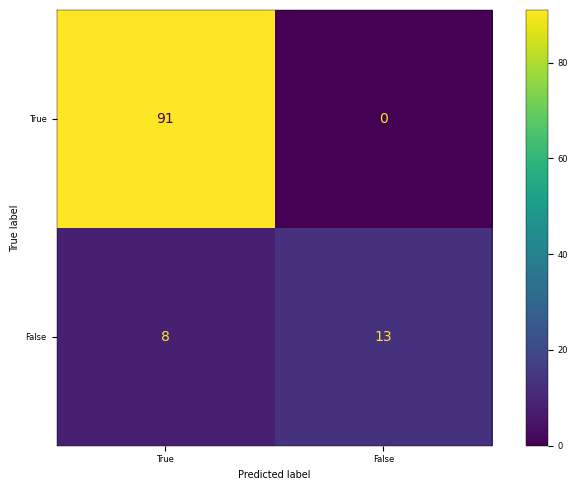

--------------------------------------------------
 Generating report for : Decission Tree model
 The Score of the trained model is -- : 1.0


 The Prediction Score  is -- : 0.9910714285714286


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.99      1.00      0.99        91
           1       1.00      0.95      0.98        21

    accuracy                           0.99       112
   macro avg       0.99      0.98      0.99       112
weighted avg       0.99      0.99      0.99       112

The Confusion matrix is 


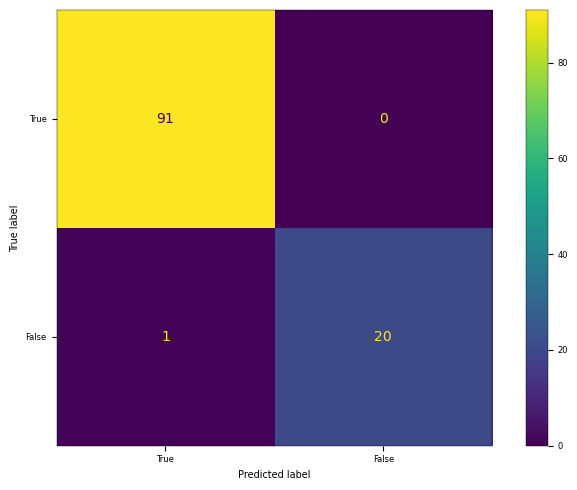

--------------------------------------------------
 Generating report for : Random Forest model
 The Score of the trained model is -- : 1.0


 The Prediction Score  is -- : 0.9732142857142857


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.97      1.00      0.98        91
           1       1.00      0.86      0.92        21

    accuracy                           0.97       112
   macro avg       0.98      0.93      0.95       112
weighted avg       0.97      0.97      0.97       112

The Confusion matrix is 


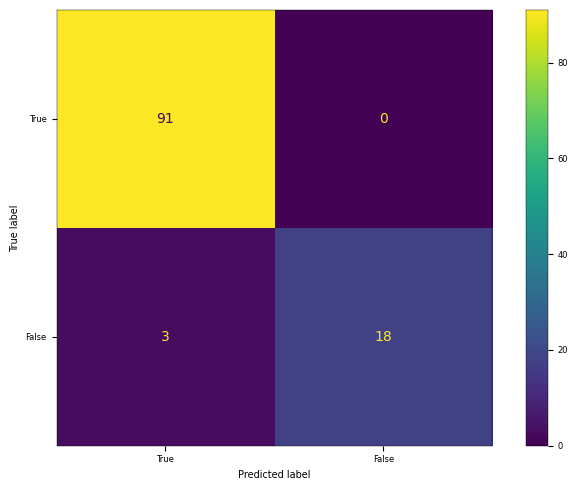

In [21]:
def validate_model(model, classsifier, X_train, X_test, y_train, y_test):
    
    print("--------------------------------------------------")
    print(" Generating report for : " + classsifier + " model")
    model.fit(X_train, y_train)
    result_train = model.score(X_train,y_train)
    print(" The Score of the trained model is -- : " +str(result_train))
    print('\n')
          
    y_predict = model.predict(X_test)
    result_test = model.score(X_test, y_test)
    print(" The Prediction Score  is -- : " +str(result_test))
    print('\n')
    
    print("The Classification Reoprt is :")
    print(classification_report(y_test, y_predict))
    
    print ("The Confusion matrix is ")
    cf_matrix = confusion_matrix(y_test, y_predict)
    #print(cf_matrix)
    cf_display = ConfusionMatrixDisplay(cf_matrix, display_labels = [True, False])
    plt.rcParams["figure.figsize"] = [7, 5]
    plt.rcParams["axes.grid"] = False
    cf_display.plot()
    plt.show()
    
    
for index in classifier_list:
    validate_model(index[0], index[1], X_train, X_test, y_train, y_test)

--------------------------------------------------
 Generating report for : XGBoost model
[10:50:43] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 The Score of the trained model is -- : 0.9678571428571429


 The Prediction Score  is -- : 0.963


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2369
           1       0.97      0.85      0.91       631

    accuracy                           0.96      3000
   macro avg       0.96      0.92      0.94      3000
weighted avg       0.96      0.96      0.96      3000

The Confusion matrix is 


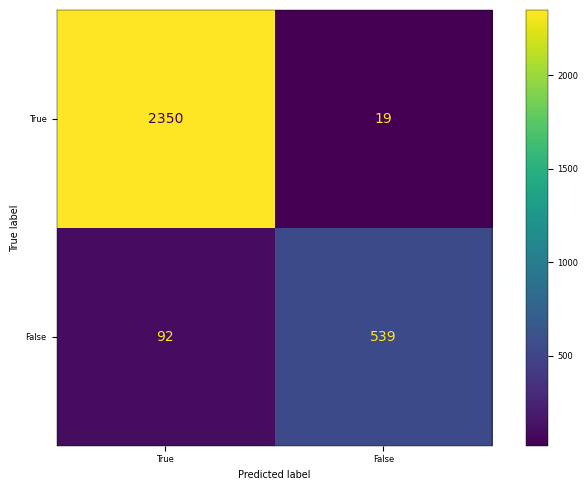

--------------------------------------------------
 Generating report for : SVM model
 The Score of the trained model is -- : 0.969


 The Prediction Score  is -- : 0.9646666666666667


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2369
           1       0.94      0.89      0.91       631

    accuracy                           0.96      3000
   macro avg       0.96      0.94      0.95      3000
weighted avg       0.96      0.96      0.96      3000

The Confusion matrix is 


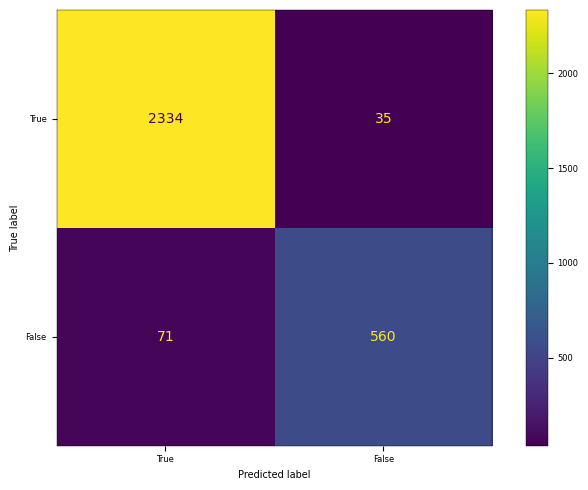

--------------------------------------------------
 Generating report for : Logistic model
 The Score of the trained model is -- : 0.9651428571428572


 The Prediction Score  is -- : 0.9626666666666667


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2369
           1       0.96      0.86      0.91       631

    accuracy                           0.96      3000
   macro avg       0.96      0.92      0.94      3000
weighted avg       0.96      0.96      0.96      3000

The Confusion matrix is 


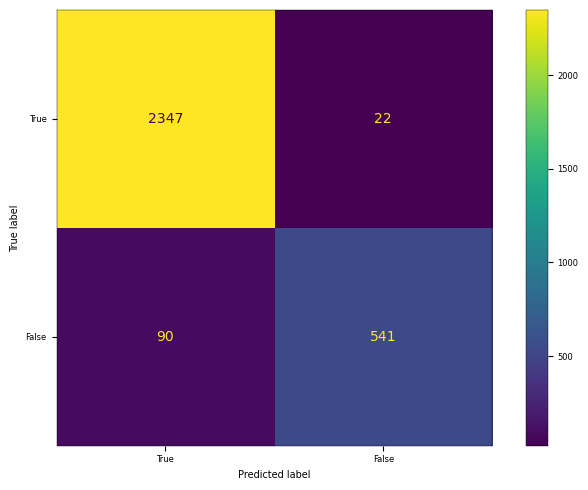

--------------------------------------------------
 Generating report for : KNN model
 The Score of the trained model is -- : 0.971


 The Prediction Score  is -- : 0.9636666666666667


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.96      0.99      0.98      2369
           1       0.96      0.86      0.91       631

    accuracy                           0.96      3000
   macro avg       0.96      0.93      0.94      3000
weighted avg       0.96      0.96      0.96      3000

The Confusion matrix is 


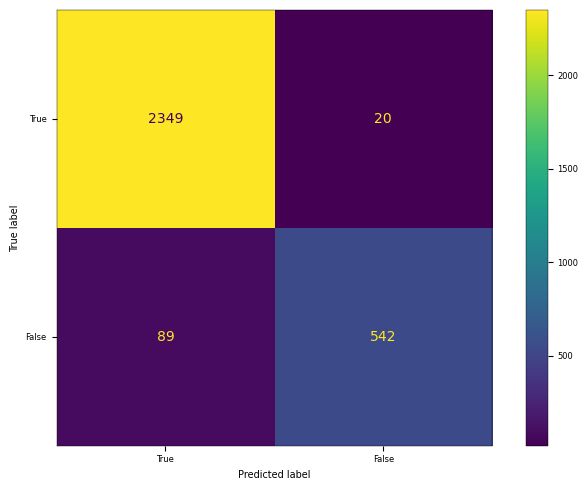

--------------------------------------------------
 Generating report for : Decission Tree model
 The Score of the trained model is -- : 0.9691428571428572


 The Prediction Score  is -- : 0.9643333333333334


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.97      0.98      0.98      2369
           1       0.94      0.89      0.91       631

    accuracy                           0.96      3000
   macro avg       0.95      0.94      0.95      3000
weighted avg       0.96      0.96      0.96      3000

The Confusion matrix is 


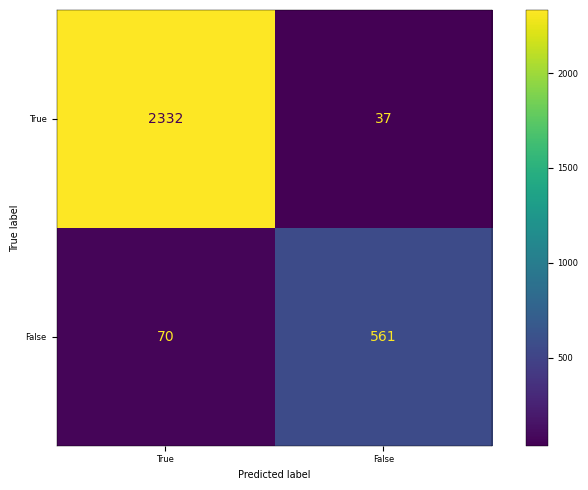

--------------------------------------------------
 Generating report for : Random Forest model
 The Score of the trained model is -- : 0.9698571428571429


 The Prediction Score  is -- : 0.966


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.97      0.99      0.98      2369
           1       0.95      0.89      0.92       631

    accuracy                           0.97      3000
   macro avg       0.96      0.94      0.95      3000
weighted avg       0.97      0.97      0.97      3000

The Confusion matrix is 


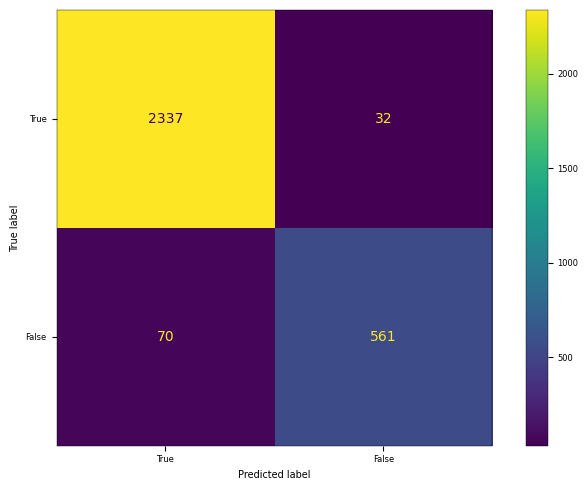

In [22]:
for index in classifier_list:
    validate_model(index[0], index[1], X_synth_train, X_synth_test, y_synth_train, y_synth_test)

# Running the test using the model trained on synthetic data and testing with real data

--------------------------------------------------
 Generating report for : XGBoost model
[10:51:56] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
 The Score of the trained model is -- : 0.8160919540229885


 The Prediction Score  is -- : 0.8035714285714286


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.81      0.99      0.89        91
           1       0.00      0.00      0.00        21

    accuracy                           0.80       112
   macro avg       0.41      0.49      0.45       112
weighted avg       0.66      0.80      0.72       112

The Confusion matrix is 


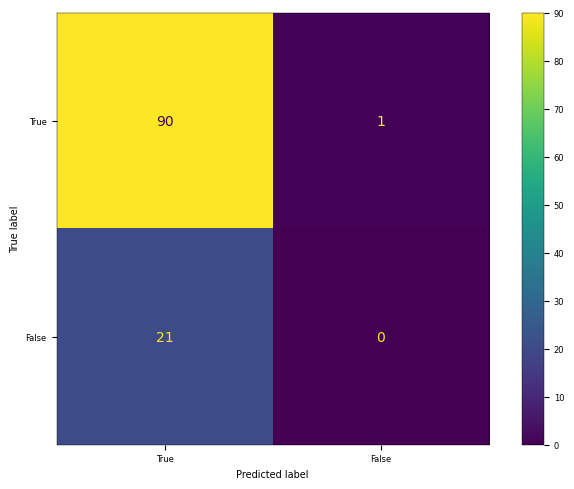

--------------------------------------------------
 Generating report for : SVM model
 The Score of the trained model is -- : 0.8237547892720306


 The Prediction Score  is -- : 0.7678571428571429


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.80      0.95      0.87        91
           1       0.00      0.00      0.00        21

    accuracy                           0.77       112
   macro avg       0.40      0.47      0.43       112
weighted avg       0.65      0.77      0.71       112

The Confusion matrix is 


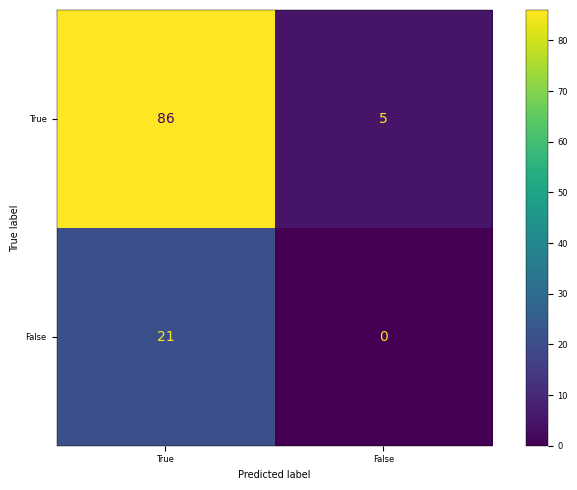

--------------------------------------------------
 Generating report for : Logistic model
 The Score of the trained model is -- : 0.8199233716475096


 The Prediction Score  is -- : 0.8035714285714286


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.81      0.99      0.89        91
           1       0.00      0.00      0.00        21

    accuracy                           0.80       112
   macro avg       0.41      0.49      0.45       112
weighted avg       0.66      0.80      0.72       112

The Confusion matrix is 


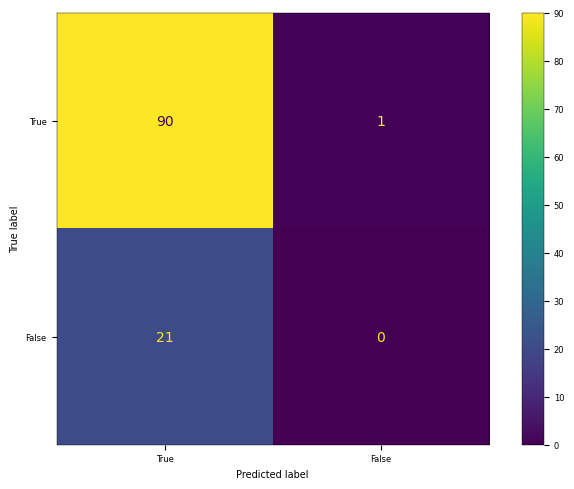

--------------------------------------------------
 Generating report for : KNN model
 The Score of the trained model is -- : 0.8045977011494253


 The Prediction Score  is -- : 0.8125


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.81      1.00      0.90        91
           1       0.00      0.00      0.00        21

    accuracy                           0.81       112
   macro avg       0.41      0.50      0.45       112
weighted avg       0.66      0.81      0.73       112

The Confusion matrix is 


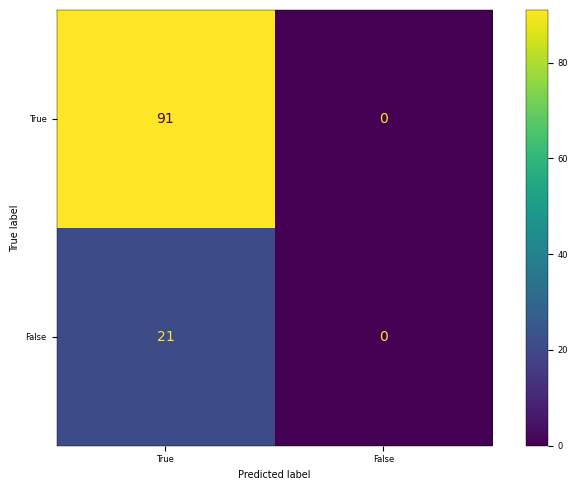

--------------------------------------------------
 Generating report for : Decission Tree model
 The Score of the trained model is -- : 0.6360153256704981


 The Prediction Score  is -- : 0.5446428571428571


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.86      0.53      0.65        91
           1       0.23      0.62      0.34        21

    accuracy                           0.54       112
   macro avg       0.54      0.57      0.50       112
weighted avg       0.74      0.54      0.59       112

The Confusion matrix is 


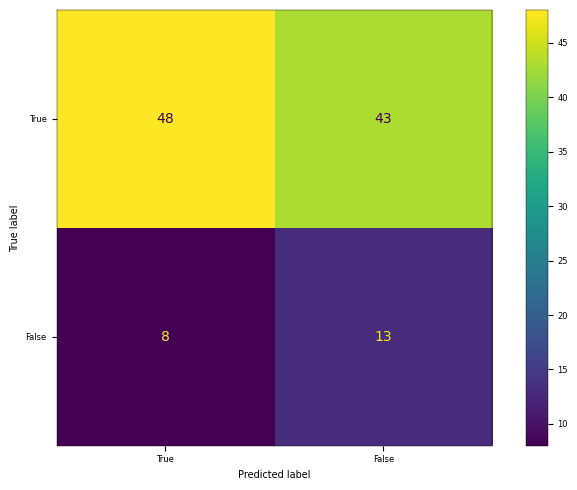

--------------------------------------------------
 Generating report for : Random Forest model
 The Score of the trained model is -- : 0.8850574712643678


 The Prediction Score  is -- : 0.7946428571428571


The Classification Reoprt is :
              precision    recall  f1-score   support

           0       0.83      0.95      0.88        91
           1       0.38      0.14      0.21        21

    accuracy                           0.79       112
   macro avg       0.60      0.54      0.54       112
weighted avg       0.74      0.79      0.76       112

The Confusion matrix is 


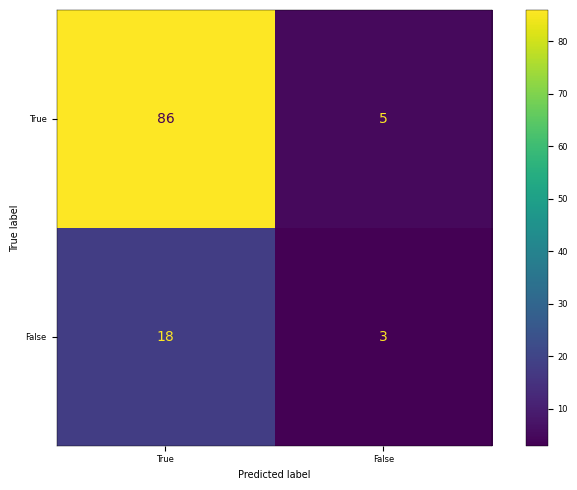

In [23]:
for index in classifier_list:
    validate_model(index[0], index[1], X_synth_train[:len(y_train)], X_synth_test[:len(y_test)], y_train, y_test)

# Plot the ROC and AUC Curves for Synthetic Data and Real Data

In [24]:
# Perform for the Real Dataset
xg_class = xgb.XGBClassifier(learning_rate = 0.3, max_depth = 5, n_estimators = 10)
xg_class.fit(X_train, y_train)
y_prob_xg = xg_class.predict_proba(X_test)[:, -1]
fpr_xg, tpr_xg, t = roc_curve(y_test, y_prob_xg)
xgp, xgr, t = precision_recall_curve(y_test, y_prob_xg)
roc_auc_xg = auc(fpr_xg, tpr_xg)
print("ROC_AUC Score - Real Data XgBoost = " +str(roc_auc_xg))

# Perform for the Synthetic Dataset
xg_class = xgb.XGBClassifier(learning_rate = 0.3, max_depth = 5, n_estimators = 10)
xg_class.fit(X_synth_train, y_synth_train)
y_prob_xg_s = xg_class.predict_proba(X_synth_test)[:, -1]
fpr_xg_s, tpr_xg_s, thresholds = roc_curve(y_synth_test, y_prob_xg_s)
xgps, xgrs, ts = precision_recall_curve(y_synth_test, y_prob_xg_s)
roc_auc_xgs = auc(fpr_xg_s, tpr_xg_s)
print("ROC_AUC Score - Synthetic Data XgBoost = " +str(roc_auc_xgs))

# Perform for the real data trained on Synthetic Dataset
xg_class = xgb.XGBClassifier(learning_rate = 0.3, max_depth = 5, n_estimators = 10)
xg_class.fit(X_synth_train, y_synth_train)
y_prob_xg_rs = xg_class.predict_proba(X_test)[:, -1]
fpr_xg_rs, tpr_xg_rs, thresholds = roc_curve(y_test, y_prob_xg_rs)
xgprs, xgrrs, ts = precision_recall_curve(y_test, y_prob_xg_rs)
roc_auc_xgrs = auc(fpr_xg_rs, tpr_xg_rs)
print("ROC_AUC Score - Trained on Synthetic Data XgBoost = " +str(roc_auc_xgrs))

# Perform for the Real Dataset
dt_class_r = DecisionTreeClassifier(max_depth = 30, 
                                  random_state=42, 
                                  max_leaf_nodes=15, 
                                  class_weight='balanced')
dt_class_r.fit(X_train, y_train)
y_prob_dt = dt_class_r.predict_proba(X_test)[:, -1]
fpr_dt, tpr_dt, t = roc_curve(y_test, y_prob_dt)
dtp, dtr, t = precision_recall_curve(y_test, y_prob_dt)
roc_auc_dt = auc(fpr_dt, tpr_dt)
print("ROC_AUC Score - Real Data DecisionTree = " +str(roc_auc_dt))

# Perform for the Synthetic Dataset
dt_class_s = DecisionTreeClassifier(max_depth = 30, 
                                  random_state=42, 
                                  max_leaf_nodes=15, 
                                  class_weight='balanced')
dt_class_s.fit(X_synth_train, y_synth_train)
y_prob_dt_s = dt_class_s.predict_proba(X_synth_test)[:, -1]
fpr_dt_s, tpr_dt_s, thresholds = roc_curve(y_synth_test, y_prob_dt_s)
dtps, dtrs, ts = precision_recall_curve(y_synth_test, y_prob_dt_s)
roc_auc_dts = auc(fpr_dt_s, tpr_dt_s)
print("ROC_AUC Score - Synthetic Data DecisionTree = " +str(roc_auc_dts))

# Perform for the real data trained on Synthetic Dataset
dt_class_x = DecisionTreeClassifier(max_depth = 30, 
                                  random_state=42, 
                                  max_leaf_nodes=15, 
                                  class_weight='balanced')
dt_class_x.fit(X_synth_train, y_synth_train)
y_prob_dt_rs = dt_class_x.predict_proba(X_test)[:, -1]
fpr_dt_rs, tpr_dt_rs, thresholds = roc_curve(y_test, y_prob_dt_rs)
dtprs, dtrrs, ts = precision_recall_curve(y_test, y_prob_dt_rs)
roc_auc_dtrs = auc(fpr_dt_rs, tpr_dt_rs)
print("ROC_AUC Score - Trained on Synthetic Data DecisionTree = " +str(roc_auc_dtrs))

# Perform for the Real Dataset
log_class = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, solver = 'saga')
log_class.fit(X_train, y_train)
y_prob_log = log_class.predict_proba(X_test)[:, -1]
fpr_log, tpr_log, t = roc_curve(y_test, y_prob_log)
logp, logr, t = precision_recall_curve(y_test, y_prob_log)
roc_auc_log = auc(fpr_log, tpr_log)
print("ROC_AUC Score - Real Data LogisticClassifier = " +str(roc_auc_log))

# Perform for the Synthetic Dataset
log_class = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, solver = 'saga')
log_class.fit(X_synth_train, y_synth_train)
y_prob_log_s = log_class.predict_proba(X_synth_test)[:, -1]
fpr_log_s, tpr_log_s, thresholds = roc_curve(y_synth_test, y_prob_log_s)
logps, logrs, ts = precision_recall_curve(y_synth_test, y_prob_log_s)
roc_auc_logs = auc(fpr_log_s, tpr_log_s)
print("ROC_AUC Score - Synthetic Data LogisticClassifier = " +str(roc_auc_logs))

# Perform for the real data trained on Synthetic Dataset
log_class = LogisticRegression(penalty='l1', dual=False, tol=0.0001, C=1.0, solver = 'saga')
log_class.fit(X_synth_train, y_synth_train)
y_prob_log_rs = log_class.predict_proba(X_test)[:, -1]
fpr_log_rs, tpr_log_rs, thresholds = roc_curve(y_test, y_prob_log_rs)
logprs, logrrs, ts = precision_recall_curve(y_test, y_prob_log_rs)
roc_auc_logrs = auc(fpr_log_rs, tpr_log_rs)
print("ROC_AUC Score - Trained on Synthetic Data LogisticClassifier = " +str(roc_auc_logrs))


# Perform for the Real Dataset
knn_class = KNeighborsClassifier(n_neighbors= 10, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                 metric='minkowski', metric_params=None, n_jobs=None)
knn_class.fit(X_train, y_train)
y_prob_knn = knn_class.predict_proba(X_test)[:, -1]
fpr_knn, tpr_knn, thresholds = roc_curve(y_test, y_prob_knn)
knnp, knnr, t = precision_recall_curve(y_test, y_prob_knn)
roc_auc_knn = auc(fpr_knn, tpr_knn)
print("ROC_AUC Score - Real Data KNNClassifier = " +str(roc_auc_knn))

# Perform for the Synthetic Dataset
knn_class = KNeighborsClassifier(n_neighbors= 10, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                 metric='minkowski', metric_params=None, n_jobs=None)
knn_class.fit(X_synth_train, y_synth_train)
y_prob_knn_s = knn_class.predict_proba(X_synth_test)[:, -1]
fpr_knn_s, tpr_knn_s, thresholds = roc_curve(y_synth_test, y_prob_knn_s)
knnps, knnrs, t = precision_recall_curve(y_synth_test, y_prob_knn_s)
roc_auc_knns = auc(fpr_knn_s, tpr_knn_s)
print("ROC_AUC Score - Synthetic Data KNNClassifier = " +str(roc_auc_knns))

# Perform for the real data trained on Synthetic Dataset
knn_class = KNeighborsClassifier(n_neighbors= 10, weights='uniform', algorithm='auto', leaf_size=30, p=2, 
                                 metric='minkowski', metric_params=None, n_jobs=None)
knn_class.fit(X_synth_train, y_synth_train)
y_prob_knn_rs = knn_class.predict_proba(X_test)[:, -1]
fpr_knn_rs, tpr_knn_rs, thresholds = roc_curve(y_test, y_prob_knn_rs)
knnprs, knnrrs, ts = precision_recall_curve(y_test, y_prob_knn_rs)
roc_auc_knnrs = auc(fpr_knn_rs, tpr_knn_rs)
print("ROC_AUC Score - Trained on Synthetic Data KNNClassifier = " +str(roc_auc_knnrs))

rf_class = RandomForestClassifier(n_estimators=10,
                                  min_samples_split=2,
                                  min_samples_leaf=1)
rf_class.fit(X_train, y_train)
y_prob_rf = rf_class.predict_proba(X_test)[:, -1]
fpr_rf, tpr_rf, thresholds = roc_curve(y_test, y_prob_rf)
rfp, rfr, t = precision_recall_curve(y_test, y_prob_rf)
roc_auc_rf = auc(fpr_rf, tpr_rf)
print("ROC_AUC Score - Real Data RandomForestClassifier = " +str(roc_auc_rf))

# Perform for the Synthetic Dataset
rf_class = RandomForestClassifier(n_estimators=10,
                                  min_samples_split=2,
                                  min_samples_leaf=1)
rf_class.fit(X_synth_train, y_synth_train)
y_prob_rf_s = rf_class.predict_proba(X_synth_test)[:, -1]
fpr_rf_s, tpr_rf_s, thresholds = roc_curve(y_synth_test, y_prob_rf_s)
rfps, rfrs, ts = precision_recall_curve(y_synth_test, y_prob_rf_s)
roc_auc_rfs = auc(fpr_rf_s, tpr_rf_s)
print("ROC_AUC Score - Synthetic Data RandomForestClassifier = " +str(roc_auc_rfs))

# Perform for the real data trained on Synthetic Dataset
rf_class = RandomForestClassifier(n_estimators=10,
                                  min_samples_split=2,
                                  min_samples_leaf=1)
rf_class.fit(X_synth_train, y_synth_train)
y_prob_rf_rs = rf_class.predict_proba(X_test)[:, -1]
fpr_rf_rs, tpr_rf_rs, thresholds = roc_curve(y_test, y_prob_rf_rs)
rfprs, rfrrs, ts = precision_recall_curve(y_test, y_prob_rf_rs)
roc_auc_rfrs = auc(fpr_rf_rs, tpr_rf_rs)
print("ROC_AUC Score - Trained on Synthetic Data RandomForestClassifier = " +str(roc_auc_rfrs))

[10:51:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC_AUC Score - Real Data XgBoost = 1.0
[10:51:58] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
ROC_AUC Score - Synthetic Data XgBoost = 0.9916114712019155
[10:51:59] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 

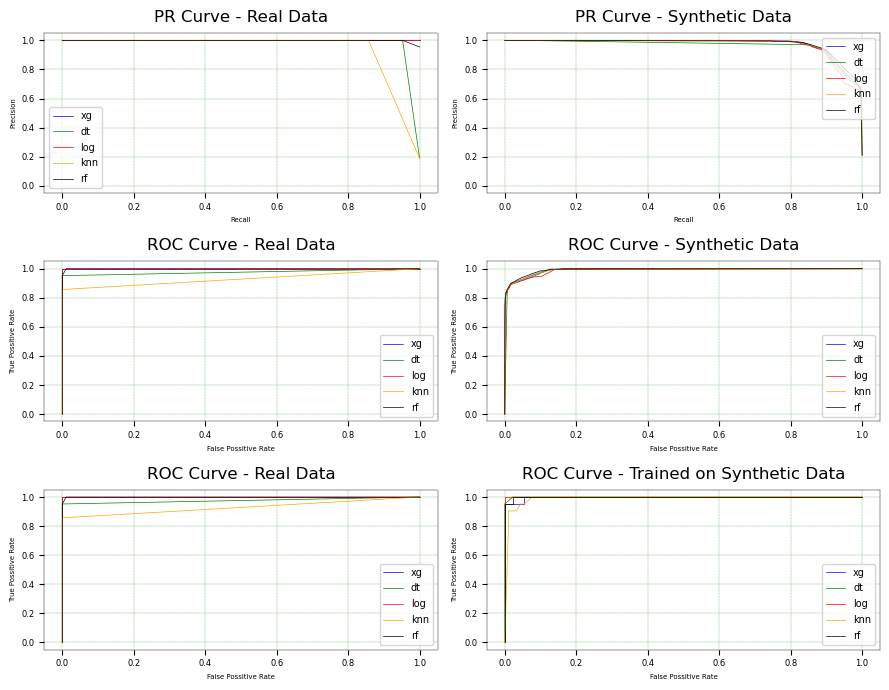

In [25]:

setplotParams()
plt.rcParams["axes.labelsize"] = 5
plt.rcParams["figure.figsize"] = [9, 7]



fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6)) = plt.subplots(3,2)

ax1.set_xlim([-0.05,1.05])
ax1.set_ylim([-0.05,1.05])
ax1.set_xlabel('Recall')
ax1.set_ylabel('Precision')
ax1.set_title('PR Curve - Real Data')
ax1.plot(xgr,xgp,c='blue',label='xg')
ax1.plot(dtr,dtp,c='green',label='dt')
ax1.plot(logr,logp,c='red',label='log')
ax1.plot(knnr,knnp,c='orange',label='knn')
ax1.plot(rfr,rfp,c='black',label='rf')

ax2.set_xlim([-0.05,1.05])
ax2.set_ylim([-0.05,1.05])
ax2.set_xlabel('Recall')
ax2.set_ylabel('Precision')
ax2.set_title('PR Curve - Synthetic Data')
ax2.plot(xgrs,xgps,c='blue',label='xg')
ax2.plot(dtrs,dtps,c='green',label='dt')
ax2.plot(logrs,logps,c='red',label='log')
ax2.plot(knnrs,knnps,c='orange',label='knn')
ax2.plot(rfrs,rfps,c='black',label='rf')

ax3.set_xlim([-0.05,1.05])
ax3.set_ylim([-0.05,1.05])
ax3.set_xlabel('False Possitive Rate')
ax3.set_ylabel('True Possitive Rate')
ax3.set_title('ROC Curve - Real Data')
ax3.plot(fpr_xg,tpr_xg,c='blue',label='xg')
ax3.plot(fpr_dt,tpr_dt,c='green',label='dt')
ax3.plot(fpr_log,tpr_log,c='red',label='log')
ax3.plot(fpr_knn,tpr_knn,c='orange',label='knn')
ax3.plot(fpr_rf,tpr_rf,c='black',label='rf')

ax4.set_xlim([-0.05,1.05])
ax4.set_ylim([-0.05,1.05])
ax4.set_xlabel('False Possitive Rate')
ax4.set_ylabel('True Possitive Rate')
ax4.set_title('ROC Curve - Synthetic Data')
ax4.plot(fpr_xg_s,tpr_xg_s,c='blue',label='xg')
ax4.plot(fpr_dt_s,tpr_dt_s,c='green',label='dt')
ax4.plot(fpr_log_s,tpr_log_s,c='red',label='log')
ax4.plot(fpr_knn_s,tpr_knn_s,c='orange',label='knn')
ax4.plot(fpr_rf_s,tpr_rf_s,c='black',label='rf')

ax5.set_xlim([-0.05,1.05])
ax5.set_ylim([-0.05,1.05])
ax5.set_xlabel('False Possitive Rate')
ax5.set_ylabel('True Possitive Rate')
ax5.set_title('ROC Curve - Real Data')
ax5.plot(fpr_xg,tpr_xg,c='blue',label='xg')
ax5.plot(fpr_dt,tpr_dt,c='green',label='dt')
ax5.plot(fpr_log,tpr_log,c='red',label='log')
ax5.plot(fpr_knn,tpr_knn,c='orange',label='knn')
ax5.plot(fpr_rf,tpr_rf,c='black',label='rf')

ax6.set_xlim([-0.05,1.05])
ax6.set_ylim([-0.05,1.05])
ax6.set_xlabel('False Possitive Rate')
ax6.set_ylabel('True Possitive Rate')
ax6.set_title('ROC Curve - Trained on Synthetic Data')
ax6.plot(fpr_xg_rs,tpr_xg_rs,c='blue',label='xg')
ax6.plot(fpr_dt_rs,tpr_dt_rs,c='green',label='dt')
ax6.plot(fpr_log_rs,tpr_log_rs,c='red',label='log')
ax6.plot(fpr_knn_rs,tpr_knn_rs,c='orange',label='knn')
ax6.plot(fpr_rf_rs,tpr_rf_rs,c='black',label='rf')


ax1.legend(loc='lower left')    
ax2.legend(loc='upper right')
ax3.legend(loc='lower right')
ax4.legend(loc='lower right')
ax5.legend(loc='lower right')
ax6.legend(loc='lower right')
plt.savefig('../Ouput Files/Malware and Anomaly/malware_ctgan.png')
plt.show()